In [ ]:
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip

--2025-12-06 10:24:10--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-06T11%3A01%3A08Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-06T10%3A00%3A23Z&ske=2025-12-06T11%3A01%3A08Z&sks=b&skv=2018-11-09&sig=sSwgWvBScXpPP754k0v%2FD22UmrNMifgk6XdEZZBcM6s%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NTAxODQ1MCwibmJmIjoxNzY1MDE2NjUwLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5i

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/test/
   creating: data/test/curly/
  inflating: data/test/curly/03312ac556a7d003f7570657f80392c34.jpg  
  inflating: data/test/curly/106dfcf4abe76990b585b2fc2e3c9f884.jpg  
  inflating: data/test/curly/1a9dbe23a0d95f1c292625960e4509184.jpg  
  inflating: data/test/curly/341ea26e6677b655f8447af56073204a4.jpg  
  inflating: data/test/curly/61aPFVrm42L._SL1352_.jpg  
  inflating: data/test/curly/6d8acb0fe980774ea4e5631198587f45.png  
  inflating: data/test/curly/7f5649a0c33a2b334f23221a52c16b9b.jpg  
  inflating: data/test/curly/90146673.jpg  
  inflating: data/test/curly/9b3608e01d78fbabc9fb0719323d507f4.jpg  
  inflating: data/test/curly/b171c99161f3cffc12d4b74488ef2fc6.jpg  
  inflating: data/test/curly/blogger_one.jpg  
  inflating: data/test/curly/c03ca1590aa4df74e922ad8257305a2b.jpg  
  inflating: data/test/curly/c1b89bb4f86a3478ec20ce1f63f003c1.jpg  
  inflating: data/test/curly/c5.jpg  
  inflating: data/test/curly/C86_76156

In [ ]:
import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from PIL import Image

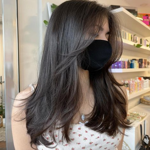

In [ ]:
img = Image.open("/content/data/train/straight/051c0f399232bd22fb8ff55a6dde5441.jpg")

img.resize((150, 150))

In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:

class HairDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:

class HairTypeCNN(nn.Module):
    def __init__(self):
        super(HairTypeCNN, self).__init__()

        # Input shape: (3, 200, 200)

        # Conv layer: 32 filters, kernel 3x3, stride 1, padding 0
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                               kernel_size=3, stride=1, padding=0)

        # ReLU activation
        self.relu = nn.ReLU()

        # Max pooling: 2x2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Compute size after conv + pooling:
        # Conv: (200 - 3 + 1) = 198 → pool → 99
        # Final feature map shape: (32, 99, 99)
        self.flatten_size = 32 * 99 * 99

        # Linear layers
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, 1)

        # Sigmoid for binary output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, self.flatten_size)  # flatten

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.sigmoid(x)

        return x


model = HairTypeCNN()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device);

In [ ]:
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

# Question 2

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
            Linear-4                   [-1, 64]      20,072,512
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 1]              65
           Sigmoid-7                    [-1, 1]               0
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 21.54
Params size (MB): 76.57
Estimated Total Size (MB): 98.57
----------------------------------------------------------------


In [ ]:
# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
train_dataset = HairDataset(
    data_dir='/content/data/train',
    transform=train_transforms
)

val_dataset = HairDataset(
    data_dir='/content/data/test',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Question 3

In [ ]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6808, Acc: 0.4869, Val Loss: 0.6676, Val Acc: 0.4876
Epoch 2/10, Loss: 0.6598, Acc: 0.4869, Val Loss: 0.6575, Val Acc: 0.4876
Epoch 3/10, Loss: 0.6446, Acc: 0.4869, Val Loss: 0.6568, Val Acc: 0.4876
Epoch 4/10, Loss: 0.6364, Acc: 0.4869, Val Loss: 0.6572, Val Acc: 0.4876
Epoch 5/10, Loss: 0.6316, Acc: 0.4869, Val Loss: 0.6561, Val Acc: 0.4876
Epoch 6/10, Loss: 0.6329, Acc: 0.4869, Val Loss: 0.6567, Val Acc: 0.4876
Epoch 7/10, Loss: 0.6234, Acc: 0.4869, Val Loss: 0.6626, Val Acc: 0.4876
Epoch 8/10, Loss: 0.6191, Acc: 0.4869, Val Loss: 0.6603, Val Acc: 0.4876
Epoch 9/10, Loss: 0.6143, Acc: 0.4869, Val Loss: 0.6655, Val Acc: 0.4876
Epoch 10/10, Loss: 0.6120, Acc: 0.4869, Val Loss: 0.6608, Val Acc: 0.4876


In [ ]:
import pandas as pd

df_hist = pd.DataFrame(history)
df_hist

,acc,loss,val_acc,val_loss
0,0.486891,0.680798,0.487562,0.667649
1,0.486891,0.659816,0.487562,0.657472
2,0.486891,0.644586,0.487562,0.656823
3,0.486891,0.636444,0.487562,0.657217
4,0.486891,0.631623,0.487562,0.656127
5,0.486891,0.632853,0.487562,0.656692
6,0.486891,0.623406,0.487562,0.662621
7,0.486891,0.619094,0.487562,0.660326
8,0.486891,0.614329,0.487562,0.665473
9,0.486891,0.611957,0.487562,0.660834


In [ ]:
df_hist["acc"].median()

0.4868913857677903

# Question 4

In [ ]:
df_hist["loss"].std()

0.021516225751587095

# Question 5

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
train_dataset = HairDataset(
    data_dir='/content/data/train',
    transform=train_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

In [ ]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6561, Acc: 0.4869, Val Loss: 0.6637, Val Acc: 0.4876
Epoch 2/10, Loss: 0.6539, Acc: 0.4869, Val Loss: 0.6526, Val Acc: 0.4876
Epoch 3/10, Loss: 0.6487, Acc: 0.4869, Val Loss: 0.6513, Val Acc: 0.4876
Epoch 4/10, Loss: 0.6465, Acc: 0.4869, Val Loss: 0.6526, Val Acc: 0.4925
Epoch 5/10, Loss: 0.6570, Acc: 0.4931, Val Loss: 0.6483, Val Acc: 0.4876
Epoch 6/10, Loss: 0.6586, Acc: 0.4919, Val Loss: 0.6482, Val Acc: 0.4925
Epoch 7/10, Loss: 0.6455, Acc: 0.4919, Val Loss: 0.6486, Val Acc: 0.4876
Epoch 8/10, Loss: 0.6468, Acc: 0.4881, Val Loss: 0.6539, Val Acc: 0.4975
Epoch 9/10, Loss: 0.6580, Acc: 0.5081, Val Loss: 0.6506, Val Acc: 0.5025
Epoch 10/10, Loss: 0.6446, Acc: 0.4919, Val Loss: 0.6506, Val Acc: 0.5075


In [ ]:
df_hist = pd.DataFrame(history)

print(df_hist["val_loss"].mean())

0.6520410054210407


# Question 6

In [ ]:
print(df_hist["val_acc"].tail(5).mean())

0.49751243781094534
